# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [1]:
!git clone https://github.com/Renass/cvr_course

fatal: destination path 'cvr_course' already exists and is not an empty directory.


In [2]:
cd cvr_course/notebooks

/content/cvr_course/notebooks


In [3]:
import glob
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
images = glob.glob('../data/imgs/arrow/*.png')
plt.rcParams["figure.figsize"] = (10,10)
for fname in images:
  img = cv2.imread(fname,cv2.IMREAD_COLOR)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  #print(img.shape)
  #fig=plt.imshow(img)
  #plt.show()

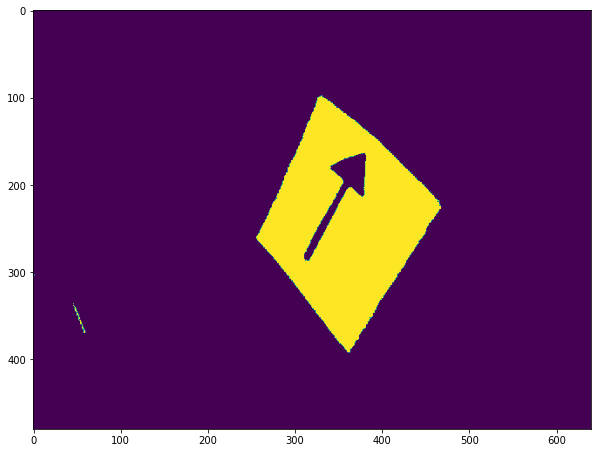

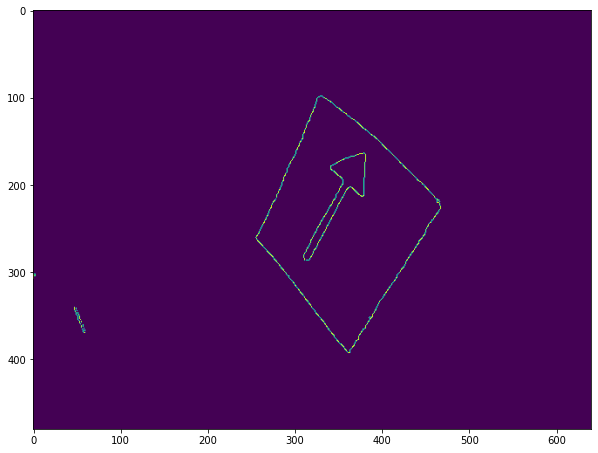

[[[467 224]]

 [[363 392]]

 [[255 260]]

 [[329  98]]]
89.37297758329687


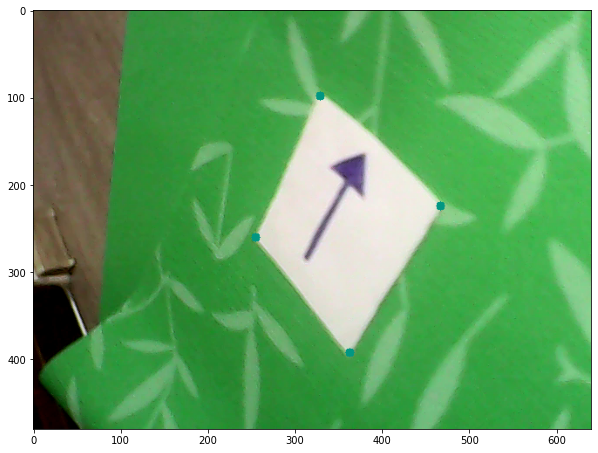

In [4]:
from random import randrange
def find_contour (img, low_th, high_th):
    mask = cv2.inRange (img, low_th, high_th)
    plt.imshow(mask)
    plt.show()

    edges=cv2.Canny(mask,100,700)
    plt.imshow(edges)
    plt.show()
    contours, hierarchy = cv2.findContours (edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1) 
    max_area=0
    for contour in contours: 
      area = cv2.contourArea(contour)
      if area> max_area:
        max_area=area
        cnt=contour  
    
    
   
    approx = cv2.convexHull (cnt)
    epsilon = 0.05 * cv2.arcLength (approx, True)
    approx = cv2.approxPolyDP (approx, epsilon, True)
    color = (randrange(255), randrange(255), randrange(255))     
    borders=cv2.drawContours(img, approx, -1, color, 10)
    plt.imshow(borders)
    return approx



def find_distance (img):
    low_th  = (180, 180, 180)
    high_th = (255, 255, 255)
    contour = find_contour (img, low_th, high_th)
    length = cv2.arcLength (contour, True)
    distance = 180.0 * 364 / length
    return distance
print(find_distance(img))